# Cover Song Identification

Cover song identification is a task of identifying when two musical recordings are derived from the same music composition. The cover of a song can be drastically different from the original recording. It can change key, tempo, instrumentation, musical structure or order, etc. 

Essentia provides open-source implmentation of some state-of-the-art cover song identification algorithms. The following process-chain is required to use these algorithms.

1. Tonal feature extraction. Mostly used by chroma features. Here we use HPCP.
2. Post-processing of the features to achieve invariance (eg. key) [3]. 
3. Cross similarity matrix computation ([1] or [2]).
4. Local sub-sequence alignment to compute the pairwise cover song similarity distance [1].


In this tutorial, we use `HPCP`, `ChromaCrossSimilarity` and `CoverSongSimilarity` algorithms from essentia.

References:

[1]. Serra, J., Serra, X., & Andrzejak, R. G. (2009). Cross recurrence quantification for cover song   identification.New Journal of Physics.
  
[2]. Serra, Joan, et al (2008). Chroma binary similarity and local alignment applied to cover song identification. IEEE Transactions on Audio, Speech, and Language Processing.

[3]. Serra, J., Gómez, E., & Herrera, P. (2008). Transposing chroma representations to a common key, IEEE Conference on The Use of Symbols to Represent Music and Multimedia Objects.

In [1]:
import essentia.standard as estd
from essentia.pytools.spectral import hpcpgram

Let's load a query cover song, true-cover reference song and a false-cover reference song.
Here we chose a accapella cover of the Beatles track `Yesterday` as our query song and it's orginal version by the  Beatles and a cover of another Beatles track `Come Together` by the Aerosmith as the reference tracks. We obtained these audio files from the covers80 dataset (https://labrosa.ee.columbia.edu/projects/coversongs/covers80/).

- Query cover song

In [3]:
import IPython
IPython.display.Audio('./en_vogue+Funky_Divas+09-Yesterday.mp3')

- Reference song (True cover)

In [4]:
IPython.display.Audio('./beatles+1+11-Yesterday.mp3')

- Reference song (False cover)

In [5]:
IPython.display.Audio('./aerosmith+Live_Bootleg+06-Come_Together.mp3')

In [6]:
# query cover song
query_audio = estd.MonoLoader(filename='./en_vogue+Funky_Divas+09-Yesterday.mp3', sampleRate=32000)()

true_cover_audio = estd.MonoLoader(filename='./beatles+1+11-Yesterday.mp3', sampleRate=32000)()

# wrong match
false_cover_audio = estd.MonoLoader(filename='./aerosmith+Live_Bootleg+06-Come_Together.mp3', sampleRate=32000)()

Now let's compute Harmonic Pitch Class Profile (HPCP) chroma features of these audio signals.

In [7]:
query_hpcp = hpcpgram(query_audio, sampleRate=32000)

true_cover_hpcp = hpcpgram(true_cover_audio, sampleRate=32000)

false_cover_hpcp = hpcpgram(false_cover_audio, sampleRate=32000)

plotting the hpcp features

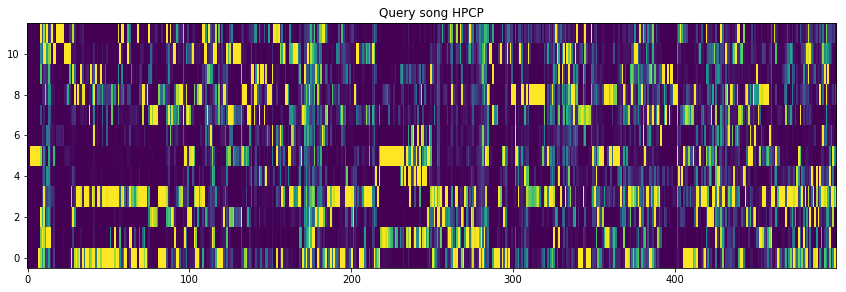

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14.5, 4.5)

plt.title("Query song HPCP")
plt.imshow(query_hpcp[:500].T, aspect='auto', origin='lower', interpolation='none')

Next steps are done using the essentia `ChromaCrossSimilarity` function,

- Stacking input features
- Key invariance using Optimal Transposition Index (OTI) [3].
- Compute binary chroma cross similarity using cross recurrent plot as described in [1] or using OTI-based chroma binary method as detailed in [3]

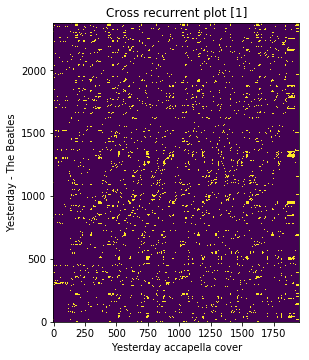

In [9]:
crp = estd.ChromaCrossSimilarity(frameStackSize=9, 
                                 frameStackStride=1, 
                                 binarizePercentile=0.095,
                                 oti=True)

true_pair_crp = crp(query_hpcp, true_cover_hpcp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cross recurrent plot [1]')
plt.xlabel('Yesterday accapella cover')
plt.ylabel('Yesterday - The Beatles')
plt.imshow(true_pair_crp, origin='lower')


Compute binary chroma cross similarity using cross recurrent plot of the non-cover pairs

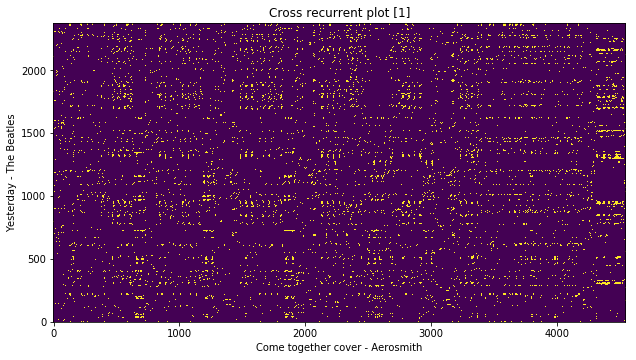

In [10]:
crp = estd.ChromaCrossSimilarity(frameStackSize=9, 
                                 frameStackStride=1, 
                                 binarizePercentile=0.095,
                                 oti=True)

false_pair_crp = crp(query_hpcp, false_cover_hpcp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cross recurrent plot [1]')
plt.xlabel('Come together cover - Aerosmith')
plt.ylabel('Yesterday - The Beatles')
plt.imshow(false_pair_crp, origin='lower')


Alternatively, you can also use the OTI-based binary similarity method as explained in [2] to compute the cross similarity of two given chroma features.

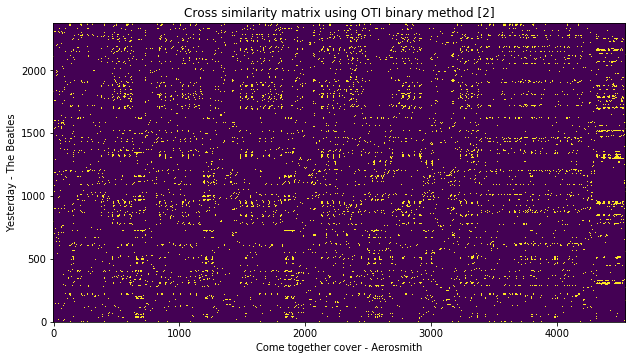

In [11]:
csm = estd.ChromaCrossSimilarity(frameStackSize=9, 
                                 frameStackStride=1, 
                                 binarizePercentile=0.095,
                                 oti=True,
                                 otiBinary=True)

oti_csm = csm(query_hpcp, false_cover_hpcp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cross similarity matrix using OTI binary method [2]')
plt.xlabel('Come together cover - Aerosmith')
plt.ylabel('Yesterday - The Beatles')
plt.imshow(oti_csm, origin='lower')

- Finally, we compute an asymmetric cover song similarity measure from the pre-computed binary cross simialrity matrix of cover/non-cover pairs using various contraints of smith-waterman sequence alignment algorithm (eg. `serra09` or `chen17`). 

Computing cover song similarity distance between 'Yesterday - accapella cover' and 'Yesterday - The Beatles'

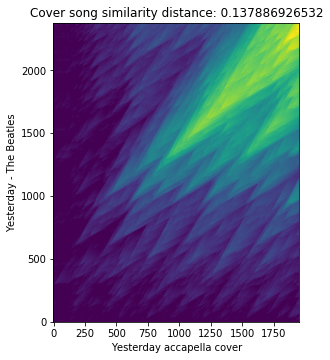

In [12]:
score_matrix, distance = estd.CoverSongSimilarity(disOnset=0.5, 
                                                  disExtension=0.5, 
                                                  alignmentType='serra09',
                                                  distanceType='asymmetric')(true_pair_crp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cover song similarity distance: %s' % distance)
plt.xlabel('Yesterday accapella cover')
plt.ylabel('Yesterday - The Beatles')
plt.imshow(score_matrix, origin='lower')

In [13]:
print('Cover song similarity distance: %s' % distance)

Cover song similarity distance: 0.137886926532


Computing cover song similarity distance between `Yesterday - accapella cover` and `Come Together cover - The Aerosmith`.

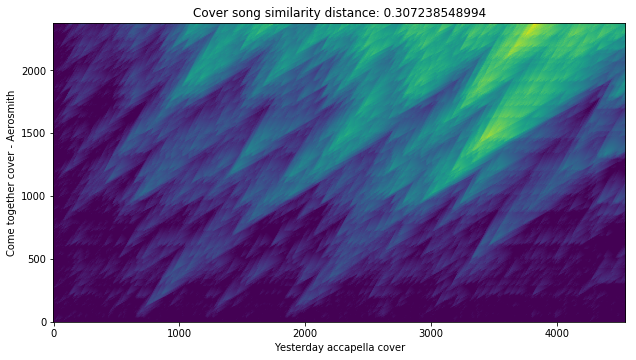

In [14]:
score_matrix, distance = estd.CoverSongSimilarity(disOnset=0.5, 
                                                  disExtension=0.5, 
                                                  alignmentType='serra09',
                                                  distanceType='asymmetric')(false_pair_crp)

fig = plt.gcf()
fig.set_size_inches(15.5, 5.5)

plt.title('Cover song similarity distance: %s' % distance)
plt.xlabel('Yesterday accapella cover')
plt.ylabel('Come together cover - Aerosmith')
plt.imshow(score_matrix, origin='lower')

In [15]:
print('Cover song similarity distance: %s' % distance)

Cover song similarity distance: 0.307238548994


Voila! 
We can see that the cover similarity distance is quite low for the actual cover song pairs as expected.